In [17]:
#single_image = r"C:\Users\danie\Desktop\tiny rainbow.jpg"
image_folder = r"C:\Users\midyr\Downloads\colorwheels"
image_pathway = r"C:\Users\midyr\Downloads\colorwheels\MicrosoftTeams-image.png"

TOO_SMALL = 20
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
height = 128
width = 128

epochs = 10 
batch_size = 1 
total_images = 1

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import glob
import cv2
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D, InputLayer, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, color
from skimage.io import imread, imshow, imsave
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [19]:
def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [20]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.png') #.jpg

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    
    print("processing", df_length, "photos for training")
    
    height_list= []
    width_list = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height_list.append(img.shape[0])
        width_list.append(img.shape[1])
        
    df["height"] = height_list
    df["width"] = width_list
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [21]:
def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
    print("PCA SHAPE",np.min(RGB_compressed),np.max(RGB_compressed))    
    return RGB_compressed

In [22]:
def rgb_pad(image):
    
    img_height = image.shape[0]
    print(height)
    img_width = image.shape[1]
    print(width)
    
    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    
    if img_height % 2 == 0:
        top = int((height - img_height)/ 2)
        bottom = int((height - img_height)/ 2)
    else: 
        top = int((height - (img_height-1))/ 2)
        bottom = int(((height - (img_height-1))/ 2)-1)

    if img_width % 2 == 0:
        left = int((width - img_width)/ 2)
        right = int((width - img_width)/ 2)
    else: 
        left = int((width - (img_width-1))/ 2)
        right = int(((width - (img_width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=WHITE)
    print(image.shape)
    print(np.min(image),np.max(image))

    return image

In [23]:
def prep_img(img_path):
    imgRGB = img_to_array(load_img(img_path))
    imgRGB = np.array(imgRGB, dtype=float)
    print('Padded:', np.min(imgRGB), np.max(imgRGB))



    image_size_category = shape(imgRGB) 
    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    if PCA_YN == "yes":
        RGB_compressed = pca_rgb(imgRGB, image_size_category)
        RGB_compressed = np.clip(RGB_compressed,0,1) * 255
        print("PCA ran")
    else:
        RGB_compressed = imgRGB
        print("PCA did not run")


    
    padded_image = rgb_pad(RGB_compressed)

    print('Padded:', np.min(padded_image), np.max(padded_image))
    X_LAB = color.rgb2lab(1.0/255*padded_image)[:,:,0] #1.0/255*padded_image
    print('X_LAB:', np.min(X_LAB), np.max(X_LAB))
    Y_LAB1 = color.rgb2lab(1.0/255*padded_image)[:,:,1:] #1.0/255*padded_image
    print('Y_LAB1:', np.min(Y_LAB1), np.max(Y_LAB1))
    Y_LAB = Y_LAB1 / 128
    print('Y_LAB:', np.min(Y_LAB), np.max(Y_LAB))


    print(X_LAB.shape)
    X = X_LAB.reshape(1, height, width, 1) #comment out when show predicted
    Y = Y_LAB.reshape(1, height, width, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [24]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

In [25]:
PCA_YN = "no"

#prep_image(single_image)

df = create_dataframe(image_folder)
prep_dataframe(df)

processing 10 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169

# MODEL

In [42]:
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCHS = 50
KERNEL_SIZE = 3
NUM_CLASSES = 2 #313
IMAGE_WIDTH = 128 #128
IMAGE_HEIGHT = 128 #128
SIGMA = 5

#early_stopping_cb = callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

In [43]:
def mode():
   
    model = tf.keras.Sequential([
    Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    UpSampling2D(size=(2, 2)),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(NUM_CLASSES, kernel_size=1, padding='same'), UpSampling2D(size=(4, 4))
        ])
    
    model.compile(optimizer ="adam", loss = "CategoricalCrossentropy", metrics = ["accuracy"])
    
    return model

In [44]:
model = mode()

In [45]:
model.build((1,128,128,1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (1, 128, 128, 32)         320       
                                                                 
 conv2d_70 (Conv2D)          (1, 64, 64, 32)           9248      
                                                                 
 batch_normalization_24 (Bat  (1, 64, 64, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (1, 64, 64, 64)           18496     
                                                                 
 conv2d_72 (Conv2D)          (1, 32, 32, 64)           36928     
                                                                 
 batch_normalization_25 (Bat  (1, 32, 32, 64)          256       
 chNormalization)                                     

In [46]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [47]:
len(X_train)

10

In [48]:
%%time
history = model.fit(train_data, batch_size = batch_size, epochs = EPOCHS, verbose = 2)  # add validation_split = 0.2

Epoch 1/50
10/10 - 2s - loss: 0.3787 - accuracy: 0.5655 - 2s/epoch - 187ms/step
Epoch 2/50
10/10 - 1s - loss: 0.1988 - accuracy: 0.4640 - 837ms/epoch - 84ms/step
Epoch 3/50
10/10 - 1s - loss: 0.2630 - accuracy: 0.4505 - 841ms/epoch - 84ms/step
Epoch 4/50
10/10 - 1s - loss: -2.8227e-01 - accuracy: 0.3029 - 823ms/epoch - 82ms/step
Epoch 5/50
10/10 - 1s - loss: -4.4099e-01 - accuracy: 0.3064 - 846ms/epoch - 85ms/step
Epoch 6/50
10/10 - 1s - loss: 0.4513 - accuracy: 0.3520 - 847ms/epoch - 85ms/step
Epoch 7/50
10/10 - 1s - loss: -2.7818e-02 - accuracy: 0.3752 - 871ms/epoch - 87ms/step
Epoch 8/50
10/10 - 1s - loss: 0.1828 - accuracy: 0.4143 - 921ms/epoch - 92ms/step
Epoch 9/50
10/10 - 1s - loss: 0.5111 - accuracy: 0.4376 - 926ms/epoch - 93ms/step
Epoch 10/50
10/10 - 1s - loss: 0.2339 - accuracy: 0.4049 - 831ms/epoch - 83ms/step
Epoch 11/50
10/10 - 1s - loss: -2.2823e-02 - accuracy: 0.3680 - 846ms/epoch - 85ms/step
Epoch 12/50
10/10 - 1s - loss: 0.4086 - accuracy: 0.5424 - 959ms/epoch - 96ms/

In [49]:
#filename = 'Singular_Model'
#model2.save(filename)
#saved_model = load_model("Singular Model")

# PREDICTION

In [50]:
def get_photo(image):
    prep_color, prep_bw = prep_img(image_pathway)
    test_predict = model.predict(prep_bw)
    
    print(np.min(test_predict[:,:,1]), np.max(test_predict[:,:,1]))
    
    test_predict_reshaped= test_predict[0,:,:,:]
    test_predict_reshaped = test_predict_reshaped*128
    BW_reshaped  = prep_bw[0,:,:,:]
    
    print(np.min(test_predict_reshaped[:,:,1]), np.max(test_predict_reshaped[:,:,1]))
    
    test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))
    test_merged_rgb = color.lab2rgb(test_merged_LAB)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(test_merged_rgb)

Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
-0.6104077 5.64633
-255.647 806.28125


C:\Users\midyr\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9564 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


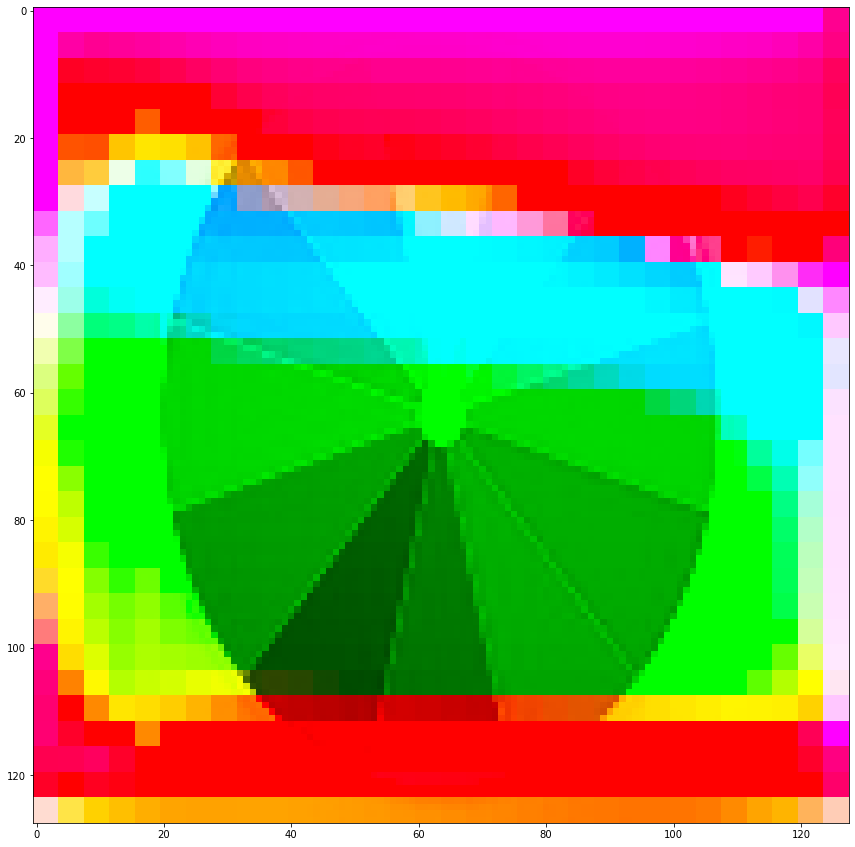

In [51]:
get_photo(image_pathway)